# Hello World Mobilenet Imagenet

## Imports

In [1]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
base_dir = '/content/drive/MyDrive/dados/HAM10000subset'
base_dir = 'HAM10000/HAM10000subset/'

## Train/test split

In [3]:
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
dataset_split_percentage = 0.75 # percentage of images for training
IMG_SHAPE = 224

for cl in classes:
    img_path = os.path.join(base_dir, cl)
    images = glob.glob(img_path + '/*.jpg')
    print("{}: {} Images".format(cl, len(images)))
    num_train = int(round(len(images) * dataset_split_percentage))
    train, val = images[:num_train], images[num_train:]

    for t in train:
        if not os.path.exists(os.path.join(base_dir, 'train', cl)):
            os.makedirs(os.path.join(base_dir, 'train', cl))
        bn=os.path.basename(t)
        if not os.path.exists(os.path.join(base_dir, 'train', cl, bn)):
            shutil.copy(t, os.path.join(base_dir, 'train', cl))

    for v in val:
        if not os.path.exists(os.path.join(base_dir, 'val', cl)):
            os.makedirs(os.path.join(base_dir, 'val', cl))
        bn = os.path.basename(v)
        if not os.path.exists(os.path.join(base_dir, 'val', cl, bn)):
            shutil.copy(v, os.path.join(base_dir, 'val', cl))

print("training images:", round(len(images)*dataset_split_percentage))
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')


akiec: 100 Images
bcc: 100 Images
bkl: 100 Images
df: 100 Images
mel: 100 Images
nv: 100 Images
vasc: 100 Images
training images: 75


In [4]:
batch_size = 16

image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5)
train_data_gen = image_gen_train.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='sparse')

image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=batch_size,
    directory=val_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='sparse')


Found 525 images belonging to 7 classes.
Found 175 images belonging to 7 classes.


## Load Mobilenet model

In [5]:
model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet')
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [7]:
model.trainable = False
base_output = model.layers[-2].output # layer number obtained from model summary above
new_output = tf.keras.layers.Dense(7, activation="softmax")(base_output)
modelMobilenetSkin = tf.keras.models.Model(inputs=model.inputs, outputs=new_output)
modelMobilenetSkin.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [8]:
modelMobilenetSkin.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

## Train

In [9]:
epochs = 10
history = modelMobilenetSkin.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size))) )


Epoch 1/10
33/33 [==============================] - 20s 560ms/step - loss: 2.0264 - accuracy: 0.2137 - val_loss: 1.8243 - val_accuracy: 0.2800
Epoch 2/10
33/33 [==============================] - 18s 533ms/step - loss: 1.6491 - accuracy: 0.3800 - val_loss: 1.6436 - val_accuracy: 0.3714
Epoch 3/10
33/33 [==============================] - 18s 542ms/step - loss: 1.5276 - accuracy: 0.4557 - val_loss: 1.5734 - val_accuracy: 0.4457
Epoch 4/10
33/33 [==============================] - 18s 555ms/step - loss: 1.4085 - accuracy: 0.4807 - val_loss: 1.5352 - val_accuracy: 0.4286
Epoch 5/10
33/33 [==============================] - 18s 546ms/step - loss: 1.3084 - accuracy: 0.5301 - val_loss: 1.5552 - val_accuracy: 0.3829
Epoch 6/10
33/33 [==============================] - 18s 537ms/step - loss: 1.2770 - accuracy: 0.5547 - val_loss: 1.5638 - val_accuracy: 0.3886
Epoch 7/10
33/33 [==============================] - 18s 535ms/step - loss: 1.1844 - accuracy: 0.5774 - val_loss: 1.4675 - val_accuracy: 0.4743

Text(0.5, 1.0, 'Training and Validation Loss')

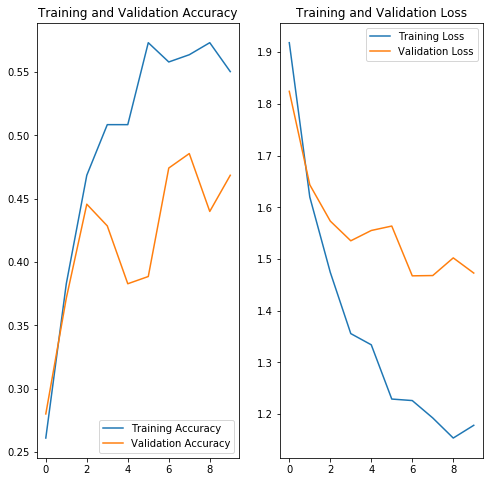

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

## Use the model to predict classes

In [11]:
num_test = int(round(700 * dataset_split_percentage))

image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(
    batch_size=num_test,
    directory=val_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='sparse')
X_test, Y_test=test_data_gen.next()

Y_predict = modelMobilenetSkin.predict(X_test)

Found 175 images belonging to 7 classes.


In [12]:
Y_predict[0]

array([0.00564126, 0.03844105, 0.2451443 , 0.48662335, 0.07545994,
       0.10685172, 0.04183837], dtype=float32)

In [13]:

Y_predicted_label = np.argmax(Y_predict, axis=-1)
Y_predicted_label

array([3, 3, 2, 4, 2, 4, 5, 3, 5, 4, 4, 1, 4, 4, 6, 5, 4, 4, 1, 0, 6, 3,
       3, 6, 6, 3, 4, 4, 5, 4, 1, 3, 6, 1, 5, 4, 6, 2, 0, 1, 6, 2, 3, 0,
       4, 3, 2, 1, 6, 1, 6, 2, 6, 4, 4, 6, 2, 4, 4, 6, 3, 4, 1, 1, 5, 5,
       6, 5, 5, 2, 2, 3, 5, 6, 1, 2, 4, 6, 6, 1, 4, 1, 3, 6, 4, 0, 4, 5,
       1, 6, 1, 1, 3, 1, 5, 6, 6, 2, 1, 5, 1, 6, 1, 2, 3, 5, 1, 0, 1, 5,
       6, 2, 1, 2, 4, 2, 4, 2, 1, 3, 1, 0, 2, 2, 1, 3, 5, 3, 4, 0, 2, 5,
       4, 4, 6, 2, 3, 1, 1, 1, 1, 2, 1, 2, 6, 4, 4, 1, 4, 4, 2, 0, 4, 4,
       5, 5, 6, 2, 0, 4, 5, 1, 1, 5, 5, 6, 2, 0, 4, 6, 2, 4, 4, 4, 4],
      dtype=int64)

In [14]:
from sklearn import metrics
cm = metrics.confusion_matrix(Y_test, Y_predicted_label, labels=[0, 1, 2, 3, 4, 5, 6])
print("Confusion Matrix:")
print(cm)

prfs = metrics.precision_recall_fscore_support(Y_test, Y_predicted_label)
print("Precision Recall F-score Support:")
print(prfs)

accuracy = metrics.accuracy_score(Y_test, Y_predicted_label)
print("Accuracy:")
print(accuracy)

cr = metrics.classification_report(Y_test, Y_predicted_label)
print("Classification Report:")
print(cr)

Confusion Matrix:
[[ 4  7  7  4  3  0  0]
 [ 0 13  4  2  4  0  2]
 [ 0  6  5  0  6  4  4]
 [ 1  1  6 10  6  1  0]
 [ 3  2  3  0 15  2  0]
 [ 2  2  0  1  4 15  1]
 [ 0  2  1  1  1  0 20]]
Precision Recall F-score Support:
(array([0.4       , 0.39393939, 0.19230769, 0.55555556, 0.38461538,
       0.68181818, 0.74074074]), array([0.16, 0.52, 0.2 , 0.4 , 0.6 , 0.6 , 0.8 ]), array([0.22857143, 0.44827586, 0.19607843, 0.46511628, 0.46875   ,
       0.63829787, 0.76923077]), array([25, 25, 25, 25, 25, 25, 25], dtype=int64))
Accuracy:
0.4685714285714286
Classification Report:
              precision    recall  f1-score   support

         0.0       0.40      0.16      0.23        25
         1.0       0.39      0.52      0.45        25
         2.0       0.19      0.20      0.20        25
         3.0       0.56      0.40      0.47        25
         4.0       0.38      0.60      0.47        25
         5.0       0.68      0.60      0.64        25
         6.0       0.74      0.80      0.77   